In [ ]:
#@title Install Required Packages

# On your local machine, uncomment them
# !pip install -qU torch, torchtext
# !pip install -qU numpy
# !pip install -qU pandas
# !pip install -qU Pillow
# !pip install -qU librosa

!mkdir -p /content/data
DATA_PATH = "/content/data"

In [ ]:
#@title Load Packages

from typing import Optional

import torch
from torch import nn as nn
from torch.nn import functional as F

import numpy as np
import pandas as pd

from PIL import Image

import librosa
import librosa.display

import nltk

import matplotlib.pyplot as plt

import copy
import os
import sys
import re
import collections
import functools
import operator

from IPython import display

%matplotlib inline

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Attention Is All You Need



<br/>
<p align="center">
    <img src="https://hooshvare.s3.ir-thr-at1.arvanstorage.com/attention_is_all_you_need.png" height="400" />
    <br/>
    <em>Figure 1: Attention Is All You Need Original Paper</em>
</p>
<br/>



# Sequence Modeling

In Sequence Modeling, the goal is to predict what word, letter, or token comes next. In other words, it is the process of generating a sequence of values by examining a series of input values. 

<br/>

Audio shape: (84800,)


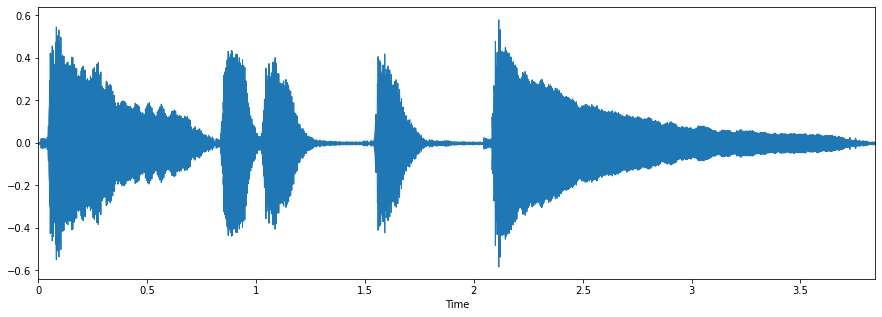

In [ ]:
#@title Audio → Sequence

!wget -q https://www.dropbox.com/s/bvdp1z7pcwgqqm2/piano.wav -P /content/data/

audio, sampling_rate = librosa.load(f"{DATA_PATH}/piano.wav")
print(f"Audio shape: {audio.shape}")

plt.figure(figsize=(15, 5))
librosa.display.waveplot(audio, sr=sampling_rate)
plt.show()

Image shape (361, 594, 4)


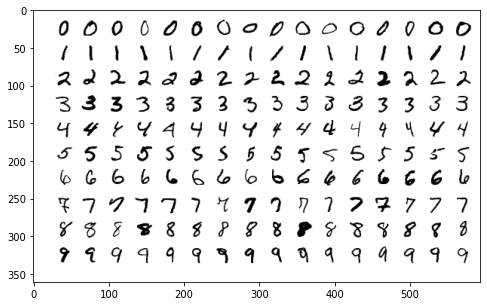

In [ ]:
#@title Image → Sequence

!wget -q https://www.dropbox.com/s/h060443ifbfc22n/mnist.png -P /content/data/

image = np.array(Image.open(f"{DATA_PATH}/mnist.png"))
print(f"Image shape {image.shape}")

plt.figure(figsize=(15, 5))
plt.imshow(image)
plt.show()

,Datetime,AEP_MW
Datetime,,
2004-10-01 01:00:00,2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,2004-10-01 05:00:00,11681.0


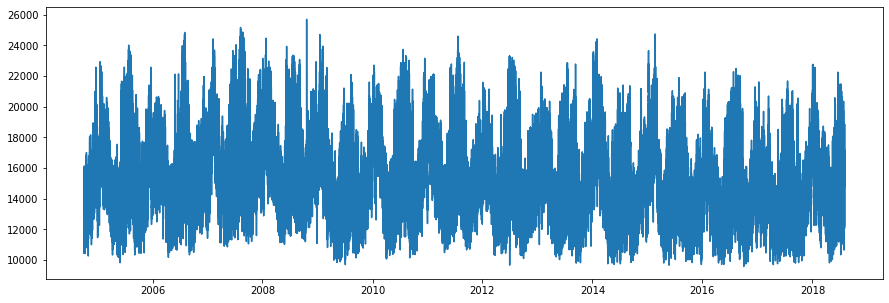

In [ ]:
#@title Time Series → Sequence

# Kaggle: https://www.kaggle.com/robikscube/hourly-energy-consumption


!wget -q https://www.dropbox.com/s/71juj4px7qktxos/AEP_hourly.csv -P /content/data/

energy_df = pd.read_csv(f"{DATA_PATH}/AEP_hourly.csv")
energy_df["Datetime"] = pd.to_datetime(energy_df["Datetime"])
energy_df.index = energy_df["Datetime"]
energy_df = energy_df.sort_index()

# Group by one-year average
energy_df.groupby(pd.Grouper(freq='1Y')).mean()

display.display(energy_df.head())
print()

plt.figure(figsize=(15, 5))
plt.plot(energy_df["Datetime"], energy_df["AEP_MW"])
plt.show()

In [ ]:
#@title Text → Sequence

# Kaggle: https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news

!wget -q https://www.dropbox.com/s/ylnzxlbsuw7ikvo/sentiment-analysis-for-financial-news.csv -P /content/data/

data = pd.read_csv(f"{DATA_PATH}/sentiment-analysis-for-financial-news.csv", encoding="ISO-8859-1", names=["sentiment", "text"])
display.display(data.head())
print()

texts = data["text"].values.tolist()

# Convert each text into corresponding words
rm_punct = re.compile(".*[A-Za-z0-9].*")
words_per_texts = [
    [word for word in nltk.tokenize.word_tokenize(text.lower()) if rm_punct.match(word)] 
    for text in texts
]

# Create vocabulary from word pool
words = functools.reduce(operator.iconcat, words_per_texts, [])
vocab = collections.Counter(words)

# Replace words with corresponding ids
words_ids_per_texts = [
    [vocab[word] for word in word_set if word in vocab]
    for word_set in words_per_texts
]

# Padding
maxlen = 10
num_samples = len(words_ids_per_texts)
input_ids = np.zeros((num_samples, maxlen), dtype=np.int)
for i, ids_set in enumerate(words_ids_per_texts):
    seqlen = min(maxlen, len(ids_set))
    input_ids[i, :seqlen] = ids_set[:seqlen]

print(input_ids.shape)
print(input_ids[:10])

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...



(4846, 10)
[[ 123 2509    2 6066  848  578   53   39 2509   22]
 [  17   39 2509   16 2969    6  326   67 3213   53]
 [6066   45   22   86  848   39  578   10   35    2]
 [ 573 6066  267  130  118 6066  848   92  103  646]
 [ 123 2509 6066  848 1000    4   38 1152 6066   50]
 [  16 3213   26 1000   65   26  930    1    1  646]
 [1152 6066   83  238 3213  238   22 1000  412  453]
 [2969 6066   73  238 3213  238  412  453  109  558]
 [ 299  409  102 2509 1015    4  515  769 1015    5]
 [ 299  409   51 1015    3  515  182  769 1015    3]]


<br/>

Sequence Modeling is a supervised learning technique that can be used to address a multi-range of applications, including time-series prediction, speech recognition, music generation, text classification, text generation, machine translation, etc.

<br/>

<p align="center">
    <img src="https://hooshvare.s3.ir-thr-at1.arvanstorage.com/sequence_modeling.jpeg" />
    <br/>
    <em>Figure 00: Sequence modeling problem</em>
</p>

<br/>

Based on the combination of the inputs and the outputs, we have five types of Sequence Modeling.

- **One to One:** Where there are one input and one output. Such as image classification.
- **One to Many:** Have single input and a sequence of outputs. Such as image captioning.
- **Many to One:** Have a sequence of inputs and a single output, such as text classification, sentiment analysis.
- **Many to Many:** Involves a sequence of inputs and a sequence of outputs. Which has two operations, all the input sequence impacts the output sequence or all the input sequence consequences as a hierarchy of effects.

# Transduction Problems

**In meaning:** Transduction (*`trans-`* **+** *`-duc-`* **+** *`-tion`*, "leading through or across")

<br/>

**In statistical theory:** Transduction refers to predicting specific examples given specific examples from a domain.

<br/>

**In linguistic:** Transduction uses transduction grammar that refers to a set of rules for transforming examples of one language into another.

# Transformer

The transformer is a model architecture that avoids recurrence and is entirely attached to the attention mechanism to draw global dependencies between input and output. 



<br/>
<p align="center">
    <img src="https://hooshvare.s3.ir-thr-at1.arvanstorage.com/transformers-model-arch.png" height="400" />
    <br/>
    <em>Figure 2: Transformer - model architecture.</em>
</p>
<br/>

Transformer maps the input sequences $(x_{1}, ..., x_{n})$ to sequences of continuous representation named as $Z = (z_{1}, ..., z_{n})$. It then generates results as sequences of symbols $(y_{1}, ..., y_{n})$ one element at a time. The model is auto-regressive at each step, consuming the previously developed characters as additional input when generating the next.


The transformer at a glance is a neural sequence transduction model that follows embedding, positional encoding, encoder blocks, and decoder blocks. Each block consists of a self-attention layer, a point-wise feed-forward layer including normalizations. 

<br/>
<p align="center">
<strong>Don't worry, we will go through them carefully!</strong>
</p>
<br/>



## Embedding

In every transduction problem, we need a way to translate tokens (tokenized text) into something computable by the machine. Mapping those inputs ids (ids of each tokenized text) into a weighted matrix called Word Token Embedding (WTE). 

**The paper shared the same weight matrix between the two embedding layers and the pre-softmax linear transformation (Multiply by $\sqrt[2]{d_{model}}$).**

In [ ]:
#@title Emedding Layer

class Embedding(nn.Module):

    def __init__(
        self,
        n_vocab: int,
        d_model: int,
        pad_idx: int = 0,
        scale_wte: bool = False
    ):
        super().__init__()

        self.n_vocab = n_vocab
        self.d_model = d_model
        self.pad_idx = pad_idx
        self.scale_wte = scale_wte

        self.wte = nn.Embedding(n_vocab, d_model, padding_idx=pad_idx)

    def forward(
        self,
        input_ids: torch.Tensor,
    ):
        # input_ids shape: (batch_size, seq_len)

        embeddings = self.wte(input_ids)

        if self.scale_wte:
            embeddings = embeddings * (self.d_model ** 0.5)

        # embeddings shape: (batch_size, seq_len, d_model)
        return embeddings

In [ ]:
#@title Encoder/Decoder inputs → Embedding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is on {device}")

zero_padding = torch.zeros((5, 5), dtype=torch.long)
x_dim = 10
y_dim = 7
d_model = 512
n_vocab = 10
pad_token_id = 0

x = torch.cat(
    [
        torch.randint(1, n_vocab, (5, x_dim), dtype=torch.long), 
        zero_padding
    ], 
    dim=1
)

y = torch.cat(
    [
        torch.randint(1, n_vocab, (5, y_dim), dtype=torch.long), 
        zero_padding
    ], 
    dim=1
)

x = x.to(device)
y = y.to(device)

print(f"X shape: {x.shape}")
print(x)
print(f"Y shape: {y.shape}")
print(y)

x_wte = Embedding(n_vocab, d_model, pad_token_id, True)
y_wte = Embedding(n_vocab, d_model, pad_token_id, True)

x_emb = x_wte(x) * (d_model ** 0.5)
print(f"X embedding shape: {x_emb.shape}")

y_emb = y_wte(y) * (d_model ** 0.5)
print(f"Y embedding shape: {y_emb.shape}")

Device is on cpu
X shape: torch.Size([5, 15])
tensor([[5, 3, 4, 5, 3, 6, 9, 2, 3, 8, 0, 0, 0, 0, 0],
        [2, 2, 5, 6, 8, 6, 3, 4, 4, 6, 0, 0, 0, 0, 0],
        [8, 9, 8, 3, 6, 8, 7, 9, 3, 1, 0, 0, 0, 0, 0],
        [3, 7, 7, 2, 2, 5, 8, 2, 4, 9, 0, 0, 0, 0, 0],
        [6, 7, 1, 2, 4, 1, 1, 7, 4, 4, 0, 0, 0, 0, 0]])
Y shape: torch.Size([5, 12])
tensor([[4, 8, 2, 5, 4, 2, 8, 0, 0, 0, 0, 0],
        [6, 6, 9, 7, 9, 1, 3, 0, 0, 0, 0, 0],
        [6, 6, 1, 5, 6, 2, 5, 0, 0, 0, 0, 0],
        [6, 1, 2, 5, 4, 8, 7, 0, 0, 0, 0, 0],
        [7, 7, 3, 1, 2, 2, 9, 0, 0, 0, 0, 0]])
X embedding shape: torch.Size([5, 15, 512])
Y embedding shape: torch.Size([5, 12, 512])


## Positional Encoding

Since the transformer declined, the recurrence and convolution need some solution to tackle the sequences' order using a relative (trainable) or absolute (fixed) position of the tokens in the sequence.

\begin{aligned}
PE_{(\textit{pos, 2i})} &= \sin (\textit{pos} / 10000^{2i / d_{model}}) \\
PE_{(\textit{pos, 2i+1})} &= \cos (\textit{pos} / 10000^{2i / d_{model}})
\end{aligned}

<br/>

This operation is used to equip each word with information about its place in a sentence. In other words, we enhance the model's input to inject the order of words. As can be derived from the function definition, the frequencies are decreasing along the vector dimension.

<br/>


**Futures**
- [Rethinking Positional Encoding in Language Pre-training](https://arxiv.org/abs/2006.15595)

In [ ]:
#@title Positional Encoding Layer

class FixedPositionalEncoding(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_position: int = 5000,
        dropout_rate: float = 0.1
    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.register_buffer(
            "positional_encoding",
            self._get_sinusoid_positional_encoding(d_model, n_position)
        )

    def _get_sinusoid_positional_encoding(
        self,
        d_model: int,
        n_position: int = 5000
    ):
        encodings = torch.zeros(n_position, d_model)
        position = torch.arange(0, n_position).unsqueeze(1)

        two_i = torch.arange(0, d_model, 2, dtype=torch.float)
        # div_term = torch.exp(two_i * -(np.log(10000.0 / d_model)))
        div_term = 1 / torch.pow(10000.0, two_i / d_model)

        encodings[:, 0::2] = torch.sin(position * div_term)  # 2i
        encodings[:, 1::2] = torch.cos(position * div_term)  # 2i+1

        # encodings = encodings.unsqueeze(1).requires_grad_(False)
        return encodings

    def forward(
        self,
        x: torch.Tensor
    ):
        # x shape: (batch_size, seq_len, d_model)
        # pe = self.positional_encoding[:x.shape[0]]
        pe = self.positional_encoding[:x.shape[1]]
        return self.dropout(x + pe)

Positional encoding related to x shape: torch.Size([5, 15, 512])
Positional encoding weights shape: (5000, 512)


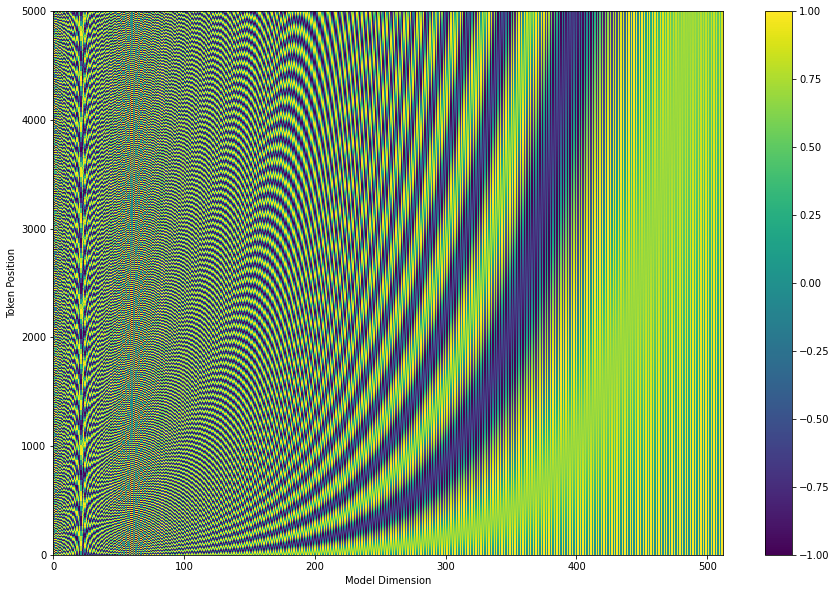

In [ ]:
#@title Positional Encoding Visualization

n_position = 5000
pe = FixedPositionalEncoding(d_model, n_position)
x_emb_pe = pe(x_emb)
print(f"Positional encoding related to x shape: {x_emb_pe.shape}")

pew = pe.positional_encoding.detach().cpu().numpy()
print(f"Positional encoding weights shape: {pew.shape}")


plt.figure(figsize=(15, 10))
plt.pcolormesh(pew, cmap="viridis")
plt.xlim((0, d_model))
plt.ylim((0, n_position))
plt.xlabel("Model Dimension")
plt.ylabel("Token Position")
plt.colorbar()
plt.show()

## Self-Attention

Self-attention is a method of understanding the other relevant words into the ones we are currently processing. In other words, self-attention allows the inputs to interact with each other (`self`) and determine who they should pay more attention to (`attention`). There are different types of attention like [Soft/Global](http://proceedings.mlr.press/v37/xuc15.pdf) and [Hard/Local](https://arxiv.org/pdf/1508.04025.pdf) attentions, which are out of our scope (You can follow them later).


> **Example:** The animal did not cross the street because it was too tired.

The crucial information in this text is that the word "*`it`*" refers to who or what? Is it referring to the "*`street`*" or to the "*`animal`*"?!

In this situation, self-attention comes in handy to declare this type of information. The word "*`it`*" is associated with "*`animal`*".


The transformer's self-attention, in fact, consists of two other parts:

- Scaled Dot-Product Attention
- Multi-Head Attention

These components improve the self-attention for three reasons

- Expanding models' ability to focus on different positions.
- It gives the attention layer multiple representation subspaces, not only one head but also various Query (Q), Key (K), and Value (V) weight matrices (WQ, WK, WV).
- Providing much faster and more space-efficient in practice

It is essential to mention that in Multi-Head attention Q, and K are the same in the encoder, while in the decoder, the encoder's output is compressed into Q.

<br/>
<p align="center">
    <img src="https://hooshvare.s3.ir-thr-at1.arvanstorage.com/transformers-self-attention-simple.png" height="400" />
    <br/>
    <em>Figure 3: Multi-Head Self Attention in detail</em>
</p>
<br/>

In a matrices form, attention weights calculate as the following. 

<br/>
<p align="center">
    <img src="https://hooshvare.s3.ir-thr-at1.arvanstorage.com/transformers-self-attention-one-head.png" />
    <br/>
    <em>Figure 4: Multi-Head Self Attention one Head</em>
</p>
<br/>


Also, we can proliferate this operation into multi-head form.

<br/>
<p align="center">
    <img src="https://hooshvare.s3.ir-thr-at1.arvanstorage.com/transformers-self-attention-two-heads.png" />
    <br/>
    <em>Figure 5: Multi-Head Self Attention Two Heads</em>
</p>
<br/>

Now suppose the real scenario, Mult-Headed self-attention in one view, is shown below.

<br/>
<p align="center">
    <img src="https://hooshvare.s3.ir-thr-at1.arvanstorage.com/transformers-self-attention-multi-heads.png" />
    <br/>
    <em>Figure 6: Multi-Headed Self Attention Muli Heads</em>
</p>
<br/>

In [ ]:
#@title Scaled Dot-Production Attention Layer

class ScaledDotProductAttention(nn.Module):

    def __init__(
        self,
        scaler: int,
        dropout_rate: float = 0.1
    ):
        super().__init__()
        self.scaler = scaler
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim=-1)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ):
        # attention shape: (batch_size, heads, seq_len, seq_len)
        # query shape: (batch_size, heads, seq_len, d_k)
        # key shape: (batch_size, heads, seq_len, d_k) -> (batch_size, heads, d_k, seq_len)
        # -> (batch_size, heads, seq_len, seq_len)
        attention = torch.matmul(query * self.scaler, key.transpose(-2, -1))

        if mask is not None:
            attention = attention.masked_fill(mask == torch.tensor(False), -1e7)

        attention = self.dropout(self.softmax(attention))

        # attention shape: (batch_size, heads, seq_len, seq_len)
        # value shape: (batch_size, heads, seq_len, d_v)
        # output shape: (batch_size, heads, seq_len, d_v)
        output = torch.matmul(attention, value)

        return output, attention


In [ ]:
#@title Multi-Head Attention Layer

class MultiHeadAttention(nn.Module):

    def __init__(
        self,
        d_model: int,
        heads: int,
        keep_attention: bool = False,
        dropout_rate: int = 0.1
    ):
        super().__init__()

        assert d_model % heads == 0, "`d_model` needs to be divisible by `heads`"

        self.d_model = d_model
        self.heads = heads
        self.keep_attention = keep_attention

        d_k = d_v = d_model // heads
        self.d_k = d_k
        self.d_v = d_v
        self.scale = 1 / (d_k ** 0.5)

        self.W_Q = nn.Linear(d_model, heads * d_k)
        self.W_K = nn.Linear(d_model, heads * d_k)
        self.W_V = nn.Linear(d_model, heads * d_v)
        self.fc = nn.Linear(heads * d_v, d_model)

        self.attention = ScaledDotProductAttention(d_k ** 0.5)
        self.dropout = nn.Dropout(dropout_rate)
        self.norm = nn.LayerNorm(d_model)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ):
        # query shape: (batch_size, seq_len, heads x d_k)
        # key shape: (batch_size, seq_len, heads x d_k)
        # value shape: (batch_size, seq_len, heads x d_v)

        batch_size = query.shape[0]
        residual = query

        # Attention projection
        # query shape: (batch_size, seq_len, heads x d_k) => (batch_size, seq_len, heads, d_k) => (batch_size, heads, seq_len, d_k)
        # key shape: (batch_size, seq_len, heads x d_k) => (batch_size, seq_len, heads, d_k) => (batch_size, heads, seq_len, d_k)
        # value shape: (batch_size, seq_len, heads x d_v) => (batch_size, seq_len, heads, d_k) => (batch_size, heads, seq_len, d_v)
        query = self.W_Q(query).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
        key = self.W_K(key).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
        value = self.W_V(value).view(batch_size, -1, self.heads, self.d_v).transpose(1, 2)

        x, attention = self.attention(query, key, value, mask=mask)

        # x (context) shape: (batch_size, heads, seq_len, d_v)
        # x reshape steps:
        # (batch_size, heads, seq_len, d_v) -> (batch_size, seq_len, heads, d_v)
        # (batch_size, seq_len, heads, d_v) -> (batch_size, seq_len, heads x d_v)
        x = x.transpose(1, 2).reshape(batch_size, -1, self.heads * self.d_v)
        x = self.dropout(self.fc(x))

        x = residual + x
        x = self.norm(x)

        if self.keep_attention:
            return x, attention.detach()

        return x

In [ ]:
#@title outputs and weights of the Attention Layer

heads = 8

attention = MultiHeadAttention(d_model, heads, keep_attention=True)

attention_outputs, attention_weights = attention(
    query=x_emb_pe,
    key=x_emb_pe,
    value=x_emb_pe,
)

print(f"Outputs shape: {attention_outputs.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Outputs shape: torch.Size([5, 15, 512])
Attention weights shape: torch.Size([5, 8, 15, 15])


## Position-Wise Feed-Forward


Contains a fully connected feed-forward network, which is applied to each position separately and identically as the following formula. 

\begin{equation}
\textit{FFN}(x)=\max (0, x W_{1}+b_{1}) W_{2}+b_{2}
\end{equation}

This layer applies to each position in the multi-head self-attention layer in parallel (each part can be thought of as a word → position-wise operation). The feed-forward layer also shares weights, so the length of the source sentence doesn’t matter.


In [ ]:
#@title Position-Wise FF Layer


class PositionWiseFeedForward(nn.Module):

    def __init__(
        self,
        d_model: int,
        d_ff: int,
        dropout_rate: float = 0.1,
        activation=nn.ReLU(),
        bias1: bool = True,
        bias2: bool = True,
    ):
        super().__init__()

        self.L1 = nn.Linear(d_model, d_ff, bias=bias1)
        self.activation = activation
        self.L2 = nn.Linear(d_ff, d_model, bias=bias2)
        self.dropout = nn.Dropout(dropout_rate)
        self.norm = nn.LayerNorm(d_model)

    def forward(
        self,
        x: torch.Tensor
    ):
        # x shape: (batch_size, seq_len, d_model)
        residual = x

        L1 = self.L1(x)
        L1 = self.activation(L1)

        L2 = self.L2(L1)
        L2 = self.dropout(L2)

        x = residual + L2
        x = self.norm(x)

        return x


In [ ]:
#@title Output of FFN

d_ff = 2048
ff = PositionWiseFeedForward(d_model, d_ff)

ff_outputs = ff(attention_outputs)
print(f"FFN's output shape: {ff_outputs.shape}")

FFN's output shape: torch.Size([5, 15, 512])


## Encoder

The encoder consists of a stack of $N = 6$ identical block layers. Each block has a multi-head self-attention layer following with normalization and a point-wise feed-forward layer following with a normalization. They employed residual connections around each of the parts.


<br/>
<p align="center">
    <img src="https://hooshvare.s3.ir-thr-at1.arvanstorage.com/transformers-encoder-arch.png" height="400" />
    <br/>
    <em>Figure 7: Transformer - encoder model</em>
</p>
<br/>

In [ ]:
#@title Encoder Layer


class EncoderLayer(nn.Module):

    def __init__(
        self,
        d_model: int,
        attention: MultiHeadAttention,
        feed_forward: PositionWiseFeedForward,
        keep_attention: bool = False
    ):
        super().__init__()

        self.d_model = d_model
        self.keep_attention = keep_attention

        self.attention = attention
        self.feed_forward = feed_forward

    def forward(
        self,
        src: torch.Tensor,
        src_mask: torch.Tensor,
    ):
        # src, src_mask
        attention_list = None

        if self.keep_attention:
            x, attention_list = self.attention(
                query=src,
                key=src,
                value=src,
                mask=src_mask
            )

        else:
            x = self.attention(
                query=src,
                key=src,
                value=src,
                mask=src_mask
            )

        x = self.feed_forward(x)

        if self.keep_attention:
            return x, attention_list

        return x

In [ ]:
#@title Encoder Model

class Encoder(nn.Module):
    def __init__(
        self,
        d_model: int,
        heads: int,
        n_layers: int,
        ff_d_ff: int,
        ff_activation: nn.Module = nn.ReLU(),
        ff_bias1: bool = True,
        ff_bias2: bool = True,
        dropout_rate: float = 0.1,
        keep_attention: bool = False
    ):
        super().__init__()

        self.d_model = d_model
        self.heads = heads
        self.ff_d_ff = ff_d_ff
        self.n_layers = n_layers
        self.ff_activation = ff_activation
        self.ff_bias1 = ff_bias1
        self.ff_bias2 = ff_bias2
        self.keep_attention = keep_attention

        attention_layer = MultiHeadAttention(
            d_model=d_model,
            heads=heads,
            dropout_rate=dropout_rate,
            keep_attention=keep_attention
        )
        ff_layer = PositionWiseFeedForward(
            d_model=d_model,
            d_ff=ff_d_ff,
            dropout_rate=dropout_rate,
            activation=ff_activation,
            bias1=ff_bias1,
            bias2=ff_bias2,
        )
        encoder_layer = EncoderLayer(
            d_model=d_model,
            attention=attention_layer,
            feed_forward=ff_layer,
            keep_attention=keep_attention
        )
        self.layers = nn.ModuleList([
            copy.deepcopy(encoder_layer) for _ in range(n_layers)
        ])

        self.norm = nn.LayerNorm(d_model)

    def forward(
        self,
        src: torch.Tensor,
        src_mask: torch.Tensor
    ):
        # src shape: (batch_size, seq_len, d_model)
        # src_mask shape: (batch_size, 1, 1, seq_len)
        attention_list_layers = []

        x = src
        for layer in self.layers:
            if self.keep_attention:
                x, attention_list = layer(src=x, src_mask=src_mask)
                attention_list_layers.extend([attention_list])
            else:
                x = layer(src=x, src_mask=src_mask)

        x = self.norm(x)

        if self.keep_attention:
            return x, attention_list_layers

        return x


In [ ]:
#@title Encoder Exmaple

encoder_args = {
    "d_model": 512,
    "heads": 8,
    "n_layers": 6,
    "ff_d_ff": 2048,
    "ff_activation": nn.ReLU(),
    "ff_bias1": True,
    "ff_bias2": True,
    "dropout_rate": 0.1,
    "keep_attention": False
}

encoder = Encoder(**encoder_args)
# encoder

In [ ]:
#@title Source Masking

def make_src_mask(
    input_ids: torch.Tensor,
    pad_idx: int = 0
):
    # input_ids shape: (batch_size, seq_len)
    # mask shape: (batch_size, 1, 1, seq_len)

    batch_size = input_ids.shape[0]

    src_mask = (input_ids != pad_idx).view(batch_size, 1, 1, -1)

    return src_mask

In [ ]:
#@title Encoder Computation Example


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is on {device}")

zero_padding = torch.zeros((5, 5), dtype=torch.long)
x_dim = 10
n_vocab = 300
pad_token_id = 0

x = torch.cat(
    [
        torch.randint(1, n_vocab, (5, x_dim), dtype=torch.long), 
        zero_padding
    ], 
    dim=1
)


x = x.to(device)
print(f"Input shape: {x.shape}")

wte = Embedding(n_vocab, encoder_args["d_model"], pad_token_id, True)
emb = wte(x) * (encoder_args["d_model"] ** 0.5)
print(f"Embedding shape: {emb.shape}")

pe = PositionalEncoding(
    encoder_args["d_model"], 
    encoder_args["dropout_rate"]
)

src = pe(emb)
src_mask = make_src_mask(x)

# src shape: (batch_size, seq_len, d_model)
print(f"Source shape: {src.shape}")

# src_mask shape: (batch_size, 1, 1, seq_len)
print(f"Source masking shape: {src_mask.shape}")

encoder_outputs = encoder(src, src_mask)
print(f"Encoder output shape: {encoder_outputs.shape}")

Device is on cpu
Input shape: torch.Size([5, 15])
Embedding shape: torch.Size([5, 15, 512])
Source shape: torch.Size([5, 15, 512])
Source masking shape: torch.Size([5, 1, 1, 15])
Encoder output shape: torch.Size([5, 15, 512])


## Decoder

The decoder consists of a stack of $N = 6$ identical block layers. Each block has a multi-head self-attention layer following with normalization, another multi-head self-attention over the encoder stack's output, and a point-wise feed-forward layer following with a normalization. They employed residual connections around each of the parts. Also, they suggested a self-attention modification with different masking. This masking, combined with the fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$. 


<br/>
<p align="center">
    <img src="https://hooshvare.s3.ir-thr-at1.arvanstorage.com/transformers-decoder-arch.png" height="400" />
    <br/>
    <em>Figure 8: Transformer - decoder model</em>
</p>
<br/>

In [ ]:
#@title Decoder Layer

class DecoderLayer(nn.Module):


    def __init__(
        self,
        d_model: int,
        attention: MultiHeadAttention,
        src_attention: MultiHeadAttention,
        feed_forward: PositionWiseFeedForward,
        keep_attention: bool = False
    ):
        super().__init__()

        self.d_model = d_model
        self.keep_attention = keep_attention

        self.attention = attention
        self.src_attention = src_attention
        self.feed_forward = feed_forward

    def forward(
        self,
        tgt: torch.Tensor,
        tgt_mask: torch.Tensor,
        src: torch.Tensor,
        src_mask: torch.Tensor
    ):
        # tgt, tgt_mask
        # src, src_mask

        attention_list = None
        src_attention_list = None

        if self.keep_attention:
            x, attention_list = self.attention(
                query=tgt,
                key=tgt,
                value=tgt,
                mask=tgt_mask
            )
        else:
            x = self.attention(
                query=tgt,
                key=tgt,
                value=tgt,
                mask=tgt_mask
            )

        if self.keep_attention:
            x, src_attention_list = self.src_attention(
                query=x,
                key=src,
                value=src,
                mask=src_mask
            )
        else:
            x = self.src_attention(
                query=x,
                key=src,
                value=src,
                mask=src_mask
            )

        x = self.feed_forward(x)

        if self.keep_attention:
            return x, [attention_list, src_attention_list]

        return x


In [ ]:
#@title Decoder Model


class Decoder(nn.Module):
    def __init__(
        self,
        d_model: int,
        heads: int,
        n_layers: int,
        ff_d_ff: int,
        ff_activation: nn.Module = nn.ReLU(),
        ff_bias1: bool = True,
        ff_bias2: bool = True,
        dropout_rate: float = 0.1,
        keep_attention: bool = False
    ):
        super().__init__()

        self.d_model = d_model
        self.heads = heads
        self.ff_d_ff = ff_d_ff
        self.n_layers = n_layers
        self.ff_activation = ff_activation
        self.ff_bias1 = ff_bias1
        self.ff_bias2 = ff_bias2
        self.keep_attention = keep_attention

        attention_layer = MultiHeadAttention(
            d_model=d_model,
            heads=heads,
            dropout_rate=dropout_rate,
            keep_attention=keep_attention
        )
        src_attention_layer = MultiHeadAttention(
            d_model=d_model,
            heads=heads,
            dropout_rate=dropout_rate,
            keep_attention=keep_attention
        )
        ff_layer = PositionWiseFeedForward(
            d_model=d_model,
            d_ff=ff_d_ff,
            dropout_rate=dropout_rate,
            activation=ff_activation,
            bias1=ff_bias1,
            bias2=ff_bias2,
        )
        decoder_layer = DecoderLayer(
            d_model=d_model,
            attention=attention_layer,
            src_attention=src_attention_layer,
            feed_forward=ff_layer,
            keep_attention=keep_attention
        )

        self.layers = nn.ModuleList([
            copy.deepcopy(decoder_layer) for _ in range(n_layers)
        ])

        self.norm = nn.LayerNorm(d_model)

    def forward(
        self,
        tgt: torch.Tensor,
        tgt_mask: torch.Tensor,
        src: torch.Tensor,
        src_mask: torch.Tensor
    ):
        # tgt shape: (batch_size, seq_len, d_model)
        # tgt_mask shape: (batch_size, 1, seq_len, seq_len)

        # src shape: (batch_size, seq_len, d_model)
        # src_mask shape: (batch_size, 1, 1, seq_len)

        attention_list_layers = []

        x = tgt
        for layer in self.layers:
            if self.keep_attention:
                x, attention_list = layer(tgt=x, tgt_mask=tgt_mask, src=src, src_mask=src_mask)
                attention_list_layers.extend([attention_list])
            else:
                x = layer(tgt=x, tgt_mask=tgt_mask, src=src, src_mask=src_mask)

        x = self.norm(x)

        if self.keep_attention:
            return x, attention_list_layers

        return x


In [ ]:
#@title Decoder Exmaple

decoder_args = {
    "d_model": 512,
    "heads": 8,
    "n_layers": 6,
    "ff_d_ff": 2048,
    "ff_activation": nn.ReLU(),
    "ff_bias1": True,
    "ff_bias2": True,
    "dropout_rate": 0.1,
    "keep_attention": False
}

decoder = Decoder(**decoder_args)
# decoder

In [ ]:
#@title Target Masking

def prepare_tgt(
    tgt: torch.Tensor,
    for_label_smoothing: bool = False
):
    # target shifting in order to learn next step
    # _tgt = tgt[:, :-1]

    if for_label_smoothing:
        return tgt[:, :-1], tgt[:, 1:].reshape(-1, 1)

    return tgt[:, :-1]


def make_tgt_mask(
    input_ids: torch.Tensor,
    pad_idx: int = 0
):
    # input_ids shape: (batch_size, seq_len)
    # mask shape: (batch_size, 1, seq_len, seq_len)

    batch_size, seq_len = input_ids.shape[:2]
    device = input_ids.device

    # tgt_padding_mask shape: (batch_size, 1, 1, seq_len)
    tgt_padding_mask = (input_ids != pad_idx).view(batch_size, 1, 1, -1)

    # tgt_nolook_forward_mask shape: (1, 1, seq_len, seq_len)
    tgt_nolook_forward_mask = torch.triu(
        torch.ones((1, 1, seq_len, seq_len), device=device)
        ==
        1
    ).transpose(2, 3)

    tgt_mask = tgt_padding_mask & tgt_nolook_forward_mask
    return tgt_mask

In [ ]:
#@title Encoder Computation Example


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is on {device}")

zero_padding = torch.zeros((5, 5), dtype=torch.long)
y_dim = 10
n_vocab = 300
pad_token_id = 0

y = torch.cat(
    [
        torch.randint(1, n_vocab, (5, y_dim), dtype=torch.long), 
        zero_padding
    ], 
    dim=1
)


y = y.to(device)
y = prepare_tgt(y)
print(f"Target shape: {y.shape}")

wte = Embedding(n_vocab, decoder_args["d_model"], pad_token_id, True)
emb = wte(y) * (decoder_args["d_model"] ** 0.5)
print(f"Embedding shape: {emb.shape}")

pe = PositionalEncoding(
    decoder_args["d_model"], 
    decoder_args["dropout_rate"]
)


tgt = pe(emb)
tgt_mask = make_tgt_mask(y)

print(f"Target shape: {tgt.shape}")
print(f"Target masking shape: {tgt_mask.shape}")


print(f"Source masking shape: {src_mask.shape}")
print(f"Encoder output shape: {encoder_outputs.shape}")

decoder_outputs = decoder(
    tgt,
    tgt_mask,
    encoder_outputs, 
    src_mask)

print(f"Decoder output shape: {decoder_outputs.shape}")

Device is on cpu
Target shape: torch.Size([5, 14])
Embedding shape: torch.Size([5, 14, 512])
Target shape: torch.Size([5, 14, 512])
Target masking shape: torch.Size([5, 1, 14, 14])
Source masking shape: torch.Size([5, 1, 1, 15])
Encoder output shape: torch.Size([5, 15, 512])
Decoder output shape: torch.Size([5, 14, 512])


# Final Version of Transformer

In [ ]:
#@title Transformer Model

class Transformer(nn.Module):

    def __init__(
        self,
        src_n_vocab: int,
        tgt_n_vocab: int,
        src_pad_idx: int,
        tgt_pad_idx: int,
        d_model: int,
        heads: int,
        ff_d_ff: int,
        n_layers: int,
        n_position: int = 5000,
        ff_activation: nn.Module = nn.ReLU(),
        ff_bias1: bool = True,
        ff_bias2: bool = True,
        dropout_rate: float = 0.1,
        scale_wte: bool = False, 
        keep_attention: bool = False
    ):
        super().__init__()

        self.src_n_vocab = src_n_vocab
        self.tgt_n_vocab = tgt_n_vocab

        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx

        self.d_model = d_model
        self.heads = heads
        self.n_layers = n_layers
        self.n_position = n_position
        self.ff_d_ff = ff_d_ff
        self.ff_activation = ff_activation
        self.ff_bias1 = ff_bias1
        self.ff_bias2 = ff_bias2
        self.keep_attention = keep_attention

        # Encoder
        self.src_wte = Embedding(src_n_vocab, d_model, pad_idx=src_pad_idx, scale_wte=scale_wte)
        self.src_pe = FixedPositionalEncoding(d_model, n_position, dropout_rate=dropout_rate)
        self.encoder = Encoder(
            d_model=d_model,
            heads=heads,
            n_layers=n_layers,
            ff_d_ff=ff_d_ff,
            ff_activation=ff_activation,
            ff_bias1=ff_bias1,
            ff_bias2=ff_bias2,
            dropout_rate=dropout_rate,
            keep_attention=keep_attention
        )

        # Decoder
        self.tgt_wte = Embedding(tgt_n_vocab, d_model, pad_idx=tgt_pad_idx, scale_wte=scale_wte)
        self.tgt_pe = FixedPositionalEncoding(d_model, n_position, dropout_rate=dropout_rate)
        self.decoder = Decoder(
            d_model=d_model,
            heads=heads,
            n_layers=n_layers,
            ff_d_ff=ff_d_ff,
            ff_activation=ff_activation,
            ff_bias1=ff_bias1,
            ff_bias2=ff_bias2,
            dropout_rate=dropout_rate,
            keep_attention=keep_attention
        )

        self.decoder_projection = nn.Linear(d_model, tgt_n_vocab)
        self.decoder_log_softmax = nn.LogSoftmax(dim=1)

        # Xavier weights initialization for all parameters
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)

    def forward(
        self,
        src_input_ids: torch.Tensor,
        src_mask: torch.Tensor,
        tgt_input_ids: torch.Tensor,
        tgt_mask: torch.Tensor
    ):
        encoded = self.encoding(src_input_ids, src_mask)
        decoded_log_probs = self.decoding(tgt_input_ids, tgt_mask, encoded, src_mask)
        return decoded_log_probs

    def encoding(
        self,
        src_input_ids: torch.Tensor,
        src_mask: torch.Tensor,
    ):
        embedding = self.src_wte(src_input_ids)
        position_embedding = self.src_pe(embedding)

        if self.keep_attention:
            encoded, attention_list = self.encoder(position_embedding, src_mask)
            return encoded, attention_list

        encoded = self.encoder(position_embedding, src_mask)
        return encoded

    def decoding(
        self,
        tgt_input_ids: torch.Tensor,
        tgt_mask: torch.Tensor,
        src_encoded: torch.Tensor,
        src_mask: torch.Tensor,
    ):
        embedding = self.src_wte(tgt_input_ids)
        position_embedding = self.src_pe(embedding)

        if self.keep_attention:
            decoded, attention_list = self.decoder(position_embedding, tgt_mask, src_encoded, src_mask)
        else:
            decoded = self.decoder(position_embedding, tgt_mask, src_encoded, src_mask)

        # shape = (batch_size, seq_len, n_vocab)
        log_probs = self.decoder_log_softmax(self.decoder_projection(decoded))

        # shape = (batch_size * seq_len, n_vocab) for label smoothing ...
        log_probs = log_probs.reshape(-1, log_probs.shape[-1])

        if self.keep_attention:
            return log_probs, attention_list

        return log_probs

In [ ]:
#@title Transformer Example


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is on {device}")

zero_padding = torch.zeros((5, 5), dtype=torch.long)
x_dim = 10
y_dim = 7


src_n_vocab = 1000
tgt_n_vocab = 1000

src_pad_idx = 0
tgt_pad_idx = 0


y = torch.cat(
    [
        torch.randint(1, src_n_vocab, (5, x_dim), dtype=torch.long), 
        zero_padding
    ], 
    dim=1
)

y = torch.cat(
    [
        torch.randint(1, tgt_n_vocab, (5, y_dim), dtype=torch.long), 
        zero_padding
    ], 
    dim=1
)


x = x.to(device)
y = y.to(device)

print(f"X shape: {x.shape}")
print(f"Y shape: {y.shape}")

transformer = Transformer(
    src_n_vocab=src_n_vocab,
    tgt_n_vocab=tgt_n_vocab,
    src_pad_idx=src_pad_idx,
    tgt_pad_idx=tgt_pad_idx,
    d_model=512,
    heads=8,
    ff_d_ff=2048,
    n_layers=6,
    n_position=5000,
    ff_activation=nn.ReLU(),
    ff_bias1=True,
    ff_bias2=True,
    dropout_rate=0.1,
    scale_wte=True,
    keep_attention=False,
)


src_input_ids = x
src_mask = make_src_mask(src_input_ids, src_pad_idx)

print(f"src_input_ids shape: {src_input_ids.shape}")
print(f"src_mask shape: {src_mask.shape}")

tgt_input_ids = y
tgt_input_ids = prepare_tgt(tgt_input_ids)
tgt_mask = make_tgt_mask(tgt_input_ids, tgt_pad_idx)

print(f"tgt_input_ids shape: {tgt_input_ids.shape}")
print(f"tgt_mask shape: {tgt_mask.shape}")

outputs = transformer(src_input_ids, src_mask, tgt_input_ids, tgt_mask)

# (batch_size * seq_len, n_vocab) => 5 * 11, 1000 
print(f"outputs shape: {outputs.shape}")

Device is on cpu
X shape: torch.Size([5, 15])
Y shape: torch.Size([5, 12])
src_input_ids shape: torch.Size([5, 15])
src_mask shape: torch.Size([5, 1, 1, 15])
tgt_input_ids shape: torch.Size([5, 11])
tgt_mask shape: torch.Size([5, 1, 11, 11])
outputs shape: torch.Size([55, 1000])
